In [6]:
import os
import numpy as np
import pandas as pd
import ast
import math
import re
import itertools
import random
import json
import matplotlib
from matplotlib.pyplot import plot as plt
from pylab import *
mpl.use("pgf")
# activate latex text rendering
rc('text', usetex=True)
rc('axes', linewidth=2)
rc('font', weight='bold')
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'text.latex.preamble':r'\usepackage{sfmath} \boldmath'
})
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
# sns.set_theme(style="ticks")


In [2]:
# load data
vcf_file = './data/HLA_recode_chr_pos.vcf'

# load genotype
genotypes = pd.read_csv(vcf_file, sep='\t', index_col=0)#.iloc[:, :-1]

headers = genotypes.columns[:]
genotypes.head()

,6_33500639,6_33500853,6_33500930,6_33501330,6_33501648,6_33501844,6_33503018,6_33503323,6_33503878,6_33504462,...,6_36596648,6_36596784,6_36597695,6_36597907,6_36598178,6_36598209,6_36598837,6_36599010,6_36599596,6_36599812
HG00096,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00097,0|0,1|0,1|0,0|0,1|0,0|0,0|0,0|0,0|0,1|0,...,0|1,0|1,0|1,0|1,0|0,0|1,0|1,0|1,0|1,0|0
HG00099,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,1|1,1|1,1|1,1|1,0|0,1|1,1|1,1|1,1|1,0|0
HG00100,0|0,0|1,0|1,0|0,0|1,0|0,0|0,0|0,0|0,0|1,...,0|1,0|1,0|1,0|1,0|0,0|1,0|1,0|1,0|1,0|0
HG00101,0|0,1|1,1|0,0|0,1|0,0|0,0|0,0|0,0|0,1|0,...,1|0,1|0,1|0,1|0,0|0,1|0,1|0,1|0,1|0,0|0


In [4]:
ped_file = './data/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [5]:
Y_train = pedigree.loc[genotypes.index]['Population']
X = genotypes[genotypes.index.isin(Y_train.index)]
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2504, 7161)

In [7]:
r = allel.rogers_huff_r(X.T)
LD = squareform(r ** 2)
LD.shape

(7161, 7161)

(array([  66.,  137.,  250.,  532., 6167.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <BarContainer object of 5 artists>)

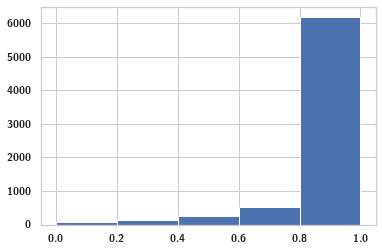

In [8]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.hist(np.max(LD, axis=1), bins=bins)

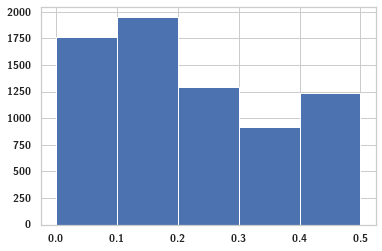

In [12]:
def freq_mapper(g):
  return 0 if g == 0 else 1 if g==1 or g==2 else 2

def bin_label_to_maf(g):
    return g/10

def maf_mapper(g):
  return min(g, 1-g)

_X = X.applymap(freq_mapper)
_X = _X.sum(axis=0)/(2*X.shape[0])
mafs = _X.map(maf_mapper)
plt.hist(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.show()

In [13]:
bin_labels = np.digitize(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5], right=True)
maf_bin_labels = np.vectorize(bin_label_to_maf)(bin_labels)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5], dtype=int64),
 array([1763, 1946, 1297,  917, 1238], dtype=int64))

In [19]:
columns = ["Fold", "MissingRate", "MAF", "Accuracy", "Sample ID"]
dfs = []
N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.01,
                       0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    file_name = f"./experimental_results/hla/maf/HLA_DEEP/HLA_DEEP_preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace({
        '0|0': 0,
        '0|1': 1,
        '1|0': 2,
        '1|1': 3
    })
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels)
        a = np.reshape(maf_bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df

Fold: 1


100%|██████████| 835/835 [00:27<00:00, 30.45it/s]


Fold: 2


100%|██████████| 835/835 [00:31<00:00, 26.12it/s]


Fold: 3


100%|██████████| 834/834 [00:33<00:00, 24.94it/s]


Combining the results...


12it [00:01,  7.42it/s]


,Fold,MissingRate,MAF,Accuracy,Sample ID
0,1,0.01,0.5,1,NA21144
1,1,0.01,0.1,1,NA21144
2,1,0.01,0.2,1,NA21144
3,1,0.01,0.5,1,NA21144
4,1,0.01,0.5,1,NA21144
...,...,...,...,...,...
6452803,3,0.2,0.4,1,HG00097
6452804,3,0.2,0.1,1,HG00097
6452805,3,0.2,0.4,1,HG00097
6452806,3,0.2,0.5,1,HG00097


In [14]:
df.to_csv("results_in_table/hla/maf/HLA_MAF_HLA_DEEP.csv")

In [15]:
df.groupby(["MissingRate", "MAF"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})

Accuracy          
                     mean       std
MissingRate MAF                    
0.01        0.1  0.988973  0.104429
            0.2  0.987220  0.112323
            0.3  0.981199  0.135823
            0.4  0.971290  0.166993
            0.5  0.983493  0.127417
0.05        0.1  0.988641  0.105972
            0.2  0.987529  0.110974
            0.3  0.981414  0.135057
            0.4  0.973590  0.160352
            0.5  0.983459  0.127545
0.10        0.1  0.988607  0.106129
            0.2  0.987480  0.111191
            0.3  0.981030  0.136418
            0.4  0.972800  0.162666
            0.5  0.983056  0.129061
0.20        0.1  0.988076  0.108542
            0.2  0.987242  0.112229
            0.3  0.980582  0.137990
            0.4  0.972173  0.164476
            0.5  0.982792  0.130046

In [16]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.01         0.983913  0.000245
0.05         0.984196  0.000192
0.10         0.983934  0.000113
0.20         0.983544  0.000128

In [20]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":["mean", "std"]})# df1.columns = df1.columns.droplevel(0)
df1

Accuracy          
                      mean       std
Fold MissingRate                    
1    0.01         0.984195  0.015248
     0.05         0.984006  0.009459
     0.10         0.983857  0.008325
     0.20         0.983489  0.008071
2    0.01         0.983790  0.016689
     0.05         0.984391  0.009287
     0.10         0.984063  0.008432
     0.20         0.983691  0.008101
3    0.01         0.983754  0.016709
     0.05         0.984191  0.009131
     0.10         0.983880  0.008413
     0.20         0.983453  0.008058

In [17]:
# print(df.groupby(["MissingRate", "MAF"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})
#             .to_latex(multirow=True))

In [21]:
columns = ["Fold", "MissingRate", "MAF", "Accuracy", "Sample ID"]
dfs = []
N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.01,
                       0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    file_name = f"./experimental_results/hla/maf/SCDA/SCDA_preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace({
        '0|0': 0,
        '0|1': 1,
        '1|0': 2,
        '1|1': 3
    })
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels)
        a = np.reshape(maf_bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df


Fold: 1


100%|██████████| 835/835 [00:31<00:00, 26.19it/s]


Fold: 2


100%|██████████| 835/835 [00:29<00:00, 28.16it/s]


Fold: 3


100%|██████████| 834/834 [00:30<00:00, 27.15it/s]


Combining the results...


12it [00:01,  8.58it/s]


,Fold,MissingRate,MAF,Accuracy,Sample ID
0,1,0.01,0.5,1,NA21144
1,1,0.01,0.1,1,NA21144
2,1,0.01,0.2,1,NA21144
3,1,0.01,0.5,1,NA21144
4,1,0.01,0.5,1,NA21144
...,...,...,...,...,...
6452803,3,0.2,0.4,1,HG00097
6452804,3,0.2,0.1,1,HG00097
6452805,3,0.2,0.4,1,HG00097
6452806,3,0.2,0.5,1,HG00097


In [22]:
df.to_csv("results_in_table/hla/maf/HLA_MAF_SCDA.csv")

In [23]:
df.groupby(["MissingRate", "MAF"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})

Accuracy          
                     mean       std
MissingRate MAF                    
0.01        0.1  0.989972  0.099640
            0.2  0.988376  0.107185
            0.3  0.983565  0.127144
            0.4  0.974130  0.158750
            0.5  0.985623  0.119041
0.05        0.1  0.989875  0.100111
            0.2  0.988649  0.105934
            0.3  0.983258  0.128305
            0.4  0.976446  0.151654
            0.5  0.986177  0.116756
0.10        0.1  0.989746  0.100742
            0.2  0.988616  0.106086
            0.3  0.983101  0.128894
            0.4  0.976637  0.151053
            0.5  0.985819  0.118235
0.20        0.1  0.989233  0.103204
            0.2  0.988174  0.108102
            0.3  0.982866  0.129772
            0.4  0.976099  0.152740
            0.5  0.985526  0.119433

In [24]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.01         0.985629  0.000602
0.05         0.985975  0.000343
0.10         0.985869  0.000288
0.20         0.985471  0.000106

In [25]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":["mean", "std"]})# df1.columns = df1.columns.droplevel(0)
df1

# print(df.groupby(["MissingRate", "MAF"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})
#             .to_latex(multirow=True))

Accuracy          
                      mean       std
Fold MissingRate                    
1    0.01         0.986287  0.013824
     0.05         0.986371  0.007960
     0.10         0.986201  0.006747
     0.20         0.985594  0.006573
2    0.01         0.985106  0.015948
     0.05         0.985759  0.008172
     0.10         0.985692  0.007079
     0.20         0.985420  0.006694
3    0.01         0.985493  0.015279
     0.05         0.985796  0.007905
     0.10         0.985714  0.006751
     0.20         0.985400  0.006520

In [26]:
columns = ["Fold", "MissingRate", "MAF", "Accuracy", "Sample ID"]
dfs = []
N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.01,
                       0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    file_name = f"./experimental_results/hla/maf/AE/AE_preds_mixed_mr_{missing_perc}_fold_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace({
        '0|0': 0,
        '0|1': 1,
        '1|0': 2,
        '1|1': 3
    })
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels)
        a = np.reshape(maf_bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df

Fold: 1


100%|██████████| 835/835 [00:31<00:00, 26.78it/s]


Fold: 2


100%|██████████| 835/835 [00:31<00:00, 26.35it/s]


Fold: 3


100%|██████████| 834/834 [00:31<00:00, 26.53it/s]


Combining the results...


12it [00:01,  9.56it/s]


,Fold,MissingRate,MAF,Accuracy,Sample ID
0,1,0.01,0.5,1,NA21144
1,1,0.01,0.1,1,NA21144
2,1,0.01,0.2,1,NA21144
3,1,0.01,0.5,1,NA21144
4,1,0.01,0.5,1,NA21144
...,...,...,...,...,...
6452803,3,0.2,0.4,1,HG00097
6452804,3,0.2,0.1,1,HG00097
6452805,3,0.2,0.4,1,HG00097
6452806,3,0.2,0.5,1,HG00097


In [27]:
df.to_csv("results_in_table/hla/maf/HLA_MAF_AE.csv")

In [28]:
df.groupby(["MissingRate", "MAF"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})

Accuracy          
                     mean       std
MissingRate MAF                    
0.01        0.1  0.839790  0.366805
            0.2  0.838343  0.368140
            0.3  0.810365  0.392018
            0.4  0.755280  0.429930
            0.5  0.821918  0.382588
0.05        0.1  0.908401  0.288460
            0.2  0.914442  0.279711
            0.3  0.892867  0.309283
            0.4  0.860432  0.346540
            0.5  0.904173  0.294355
0.10        0.1  0.929104  0.256651
            0.2  0.933103  0.249844
            0.3  0.915010  0.278867
            0.4  0.888222  0.315093
            0.5  0.922537  0.267325
0.20        0.1  0.932475  0.250930
            0.2  0.936005  0.244745
            0.3  0.918135  0.274158
            0.4  0.892596  0.309627
            0.5  0.925263  0.262967

In [29]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1


Accuracy          
                 mean       std
MissingRate                    
0.01         0.820283  0.002674
0.05         0.900321  0.001239
0.10         0.921239  0.001013
0.20         0.924491  0.001688

In [30]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":["mean", "std"]})# df1.columns = df1.columns.droplevel(0)
df1

Accuracy          
                      mean       std
Fold MissingRate                    
1    0.01         0.818352  0.076006
     0.05         0.901636  0.048527
     0.10         0.920137  0.041559
     0.20         0.923285  0.037912
2    0.01         0.819162  0.071894
     0.05         0.899174  0.048158
     0.10         0.921450  0.038833
     0.20         0.923768  0.036379
3    0.01         0.823336  0.072803
     0.05         0.900155  0.049380
     0.10         0.922129  0.040155
     0.20         0.926420  0.036594

In [ ]:
# print(df.groupby(["MissingRate", "MAF"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})
#            .to_latex(multirow=True))

In [ ]:
columns = ["Fold", "MissingRate", "MAF", "Accuracy", "Sample ID"]
dfs = []
N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.01,
                       0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    file_name = f"./experimental_results/hla/maf/STI/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace({
        '0|0': 0,
        '0|1': 1,
        '1|0': 2,
        '1|1': 3
    })
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels)
        a = np.reshape(maf_bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df

In [ ]:
df.to_csv("results_in_table/hla/maf/HLA_MAF_STI.csv")

In [ ]:
df1 = df.groupby(["Fold", "MissingRate", "MAF", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate", "MAF"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate", "MAF"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

In [ ]:
# df.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})

df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

In [11]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":["mean", "std"]})# df1.columns = df1.columns.droplevel(0)
df1

Accuracy          
                      mean       std
Fold MissingRate                    
1    0.01         0.991718  0.010755
     0.05         0.991336  0.005688
     0.10         0.991071  0.004740
     0.20         0.990647  0.004160
2    0.01         0.990284  0.012965
     0.05         0.991008  0.006433
     0.10         0.990734  0.005270
     0.20         0.990504  0.004533
3    0.01         0.991708  0.010889
     0.05         0.991546  0.005671
     0.10         0.991131  0.004975
     0.20         0.990867  0.004212

In [ ]:
print(
df.groupby(["MissingRate", "MAF"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})
    .to_latex(multirow=True)
)

In [14]:
columns = ["Fold", "MissingRate", "MAF", "Accuracy", "Sample ID"]
dfs = []
N_SPLITS=3
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1
  print(f"Fold: {fold}")
  y = _x[test_index]
  for missing_perc in [0.01,
                       0.05,
                       0.1,
                       0.2]:
    dataframe = pd.DataFrame(columns = columns)
    file_name = f"./experimental_results/hla/maf/STI_wo_emb/preds_mixed_mr_{missing_perc}_rs_{fold}_.csv"
    result_genotypes = pd.read_csv(file_name, index_col=0)
    result_genotypes = result_genotypes.replace({
        '0|0': 0,
        '0|1': 1,
        '1|0': 2,
        '1|1': 3
    })
    yhat = result_genotypes.to_numpy()
    assert y.shape == yhat.shape
    for i in tqdm(list(range(y.shape[0]))):
        missing_index, _ = train_test_split(np.arange(y.shape[1]), train_size=missing_perc,
                                            random_state=i + fold,
                                            shuffle=True,
                                            stratify=bin_labels)
        a = np.reshape(maf_bin_labels[missing_index], (-1, 1))
        b = np.array([fold for _ in missing_index]).reshape((-1, 1))
        c = np.array([missing_perc for _ in missing_index]).reshape((-1, 1))
        d = (yhat[i, missing_index]==y[i, missing_index]).astype(int).reshape((-1, 1))
        e = np.array([X.index[test_index][i] for _ in missing_index]).astype(object).reshape((-1, 1))
        dataframe = pd.concat([pd.DataFrame(np.concatenate([b,c,a,d,e], axis=1), columns=dataframe.columns), dataframe], ignore_index=True)
    dfs.append(dataframe)

df = pd.DataFrame(columns = columns)
print("Combining the results...")
for i, dff in tqdm(enumerate(dfs)):
    df = pd.concat([df, dff], ignore_index=True)
del dfs

df

Fold: 1


100%|██████████| 835/835 [00:29<00:00, 28.53it/s]


Fold: 2


100%|██████████| 835/835 [00:30<00:00, 27.73it/s]


Fold: 3


100%|██████████| 834/834 [00:28<00:00, 29.15it/s]


Combining the results...


12it [00:01,  9.09it/s]


,Fold,MissingRate,MAF,Accuracy,Sample ID
0,1,0.01,0.5,1,NA21144
1,1,0.01,0.1,1,NA21144
2,1,0.01,0.2,1,NA21144
3,1,0.01,0.5,1,NA21144
4,1,0.01,0.5,1,NA21144
...,...,...,...,...,...
6452803,3,0.2,0.4,1,HG00097
6452804,3,0.2,0.1,1,HG00097
6452805,3,0.2,0.4,1,HG00097
6452806,3,0.2,0.5,1,HG00097


In [15]:
df.to_csv("results_in_table/hla/maf/HLA_MAF_STI_wo_emb.csv")

In [16]:
df1 = df.groupby(["Fold", "MissingRate", "MAF", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate", "MAF"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate", "MAF"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                     mean       std
MissingRate MAF                    
0.01        0.1  0.989772  0.001533
            0.2  0.989112  0.000357
            0.3  0.983288  0.001001
            0.4  0.975728  0.001214
            0.5  0.986555  0.001754
0.05        0.1  0.990152  0.000683
            0.2  0.989011  0.000271
            0.3  0.983792  0.000813
            0.4  0.977697  0.001102
            0.5  0.986621  0.001050
0.10        0.1  0.990095  0.000625
            0.2  0.989090  0.000500
            0.3  0.983909  0.000893
            0.4  0.977666  0.000809
            0.5  0.986232  0.000840
0.20        0.1  0.989950  0.000606
            0.2  0.988851  0.000328
            0.3  0.983436  0.000978
            0.4  0.976942  0.000721
            0.5  0.985902  0.000645

In [17]:
# df.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]}).round({'mean': 4})#.rename(columns={"Accuracy": "Max Accuracy"})

df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":"mean"}).reset_index()# df1.columns = df1.columns.droplevel(0)
df1 = df1.groupby(["MissingRate"]).agg( {"Accuracy":["mean", "std"]})#.reset_index()
df1

Accuracy          
                 mean       std
MissingRate                    
0.01         0.986084  0.000918
0.05         0.986476  0.000603
0.10         0.986433  0.000682
0.20         0.986110  0.000590

In [18]:
df1 = df.groupby(["Fold", "MissingRate", "Sample ID"]).agg( {"Accuracy":"mean"}).reset_index()
df1 = df1.groupby(["Fold", "MissingRate"]).agg( {"Accuracy":["mean", "std"]})# df1.columns = df1.columns.droplevel(0)
df1

Accuracy          
                      mean       std
Fold MissingRate                    
1    0.01         0.986759  0.013665
     0.05         0.986997  0.007322
     0.10         0.987111  0.005876
     0.20         0.986774  0.005627
2    0.01         0.985038  0.015289
     0.05         0.985816  0.008454
     0.10         0.985746  0.007092
     0.20         0.985648  0.006593
3    0.01         0.986456  0.015220
     0.05         0.986616  0.007974
     0.10         0.986444  0.006749
     0.20         0.985907  0.006342